# MLP Classifier

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import reduce_memory_usage
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import seaborn as sns

from sklearn import metrics, model_selection, tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.compose import ColumnTransformer
from itertools import cycle

%matplotlib inline
pd.set_option("display.max_columns", None)

warnings.filterwarnings('ignore')

## Functions

In [2]:
def get_model_metrics(y_val, predictions, model_name):
    conf_matrix = confusion_matrix(y_val, predictions)
    accu = accuracy_score(y_val, predictions)
    _recall_score = recall_score(y_val, predictions, average='weighted')
    _precision_score = precision_score(y_val, predictions, average='weighted')
    _f1_score = f1_score(y_val, predictions, average='weighted')

    print(f"\n---Metrics for {model_name}---")
    print("\n Confusion Matrix\n", conf_matrix)
    print("\n Accuracy", accu)
    print("\n Precision", _precision_score)
    print("\n Recall", _recall_score)
    print("\n F1 Score", _f1_score)
    
    return conf_matrix


In [3]:
def get_roc_curves(y, y_pred):
    y_ = label_binarize(y, classes=[0, 1])
    pred = label_binarize(y_pred, classes=[0,1])
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes=1
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_.ravel(), pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(
        fpr[0],
        tpr[0],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[0],
    )
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def k_fold_val(model, X, y, model_name, splits=5):
    # Validation of model after train with train data
    k_folds_model_train = model_selection.KFold(n_splits=splits, shuffle=True, random_state=79)
    k_folds_model_train.get_n_splits(X)
    scores = model_selection.cross_val_score(model, X, y, cv=k_folds_model_train)
    print(f"---k-fold scores for {model_name}---")
    print("Scores are: ", scores)
    print("Mean is: ", np.mean(scores))
    print("STD is: +-", np.std(scores))

## Load Data

In [5]:
X_columns = ['AVProductsInstalled',
             'SmartScreen',
             'AVProductStatesIdentifier',
             'Census_OSArchitecture',
             'AppVersion_2',
             'Census_TotalPhysicalRAM',
             'IsProtected',
             'EngineVersion',
             'Census_SystemVolumeTotalCapacity',
             'AppVersion_3',
             'Census_FirmwareVersionIdentifier',
             'Census_ProcessorModelIdentifier',
             'Census_OEMModelIdentifier',
             'CountryIdentifier',
             'OrganizationIdentifier'
             ]

target = ['HasDetections']

In [6]:
df = pd.read_csv('./datasets/train_preprocessed.csv', usecols=X_columns+target)

In [7]:
# Warn: Do not execute except hardware limitations
# df = df.sample(frac=0.25)

In [8]:
df.shape

(7667792, 16)

In [9]:
X = df.drop("HasDetections", axis=1)
y = df["HasDetections"]

del df

## Data Split & Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [11]:
clf = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=40, early_stopping=True, verbose=True))

In [12]:
clf.fit(X_train, y_train)

Iteration 1, loss = 0.64084190
Validation score: 0.625533
Iteration 2, loss = 0.63435169
Validation score: 0.628184
Iteration 3, loss = 0.63348356
Validation score: 0.628339
Iteration 4, loss = 0.63297108
Validation score: 0.627802
Iteration 5, loss = 0.63262449
Validation score: 0.628472
Iteration 6, loss = 0.63235500
Validation score: 0.630251
Iteration 7, loss = 0.63218080
Validation score: 0.629439
Iteration 8, loss = 0.63198583
Validation score: 0.630153
Iteration 9, loss = 0.63185306
Validation score: 0.630261
Iteration 10, loss = 0.63175419
Validation score: 0.630220
Iteration 11, loss = 0.63166660
Validation score: 0.630856
Iteration 12, loss = 0.63158123
Validation score: 0.629576
Iteration 13, loss = 0.63148075
Validation score: 0.630460
Iteration 14, loss = 0.63141243
Validation score: 0.631244
Iteration 15, loss = 0.63129409
Validation score: 0.631258
Iteration 16, loss = 0.63123990
Validation score: 0.630993
Iteration 17, loss = 0.63116609
Validation score: 0.631307
Iterat

/Users/gusmendez99/Documents/SDS/sds-project-2/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(early_stopping=True, max_iter=40, random_state=1,
                               verbose=True))])

## Metrics

In [13]:
predictions = clf.predict(X_test)

In [14]:
conf_matrix = get_model_metrics(y_test, predictions, "MLPClassifier")


---Metrics for MLPClassifier---

 Confusion Matrix
 [[481136 282750]
 [282551 487122]]

 Accuracy 0.6313796860766361

 Precision 0.6313793339135414

 Recall 0.6313796860766361

 F1 Score 0.6313794993635778


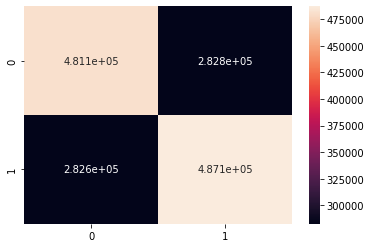

In [15]:
sns.heatmap(conf_matrix, annot=True, fmt=".4g");

## ROC Curve

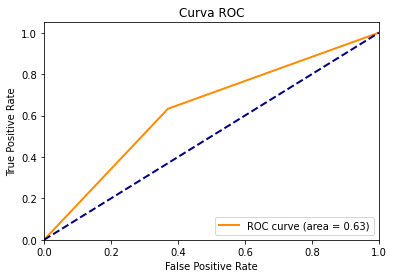

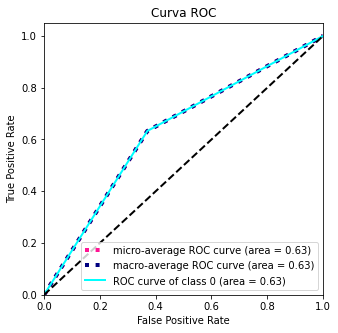

In [16]:
get_roc_curves(y_test, predictions)

## K - Folds (Cross Validation)

In [17]:
k_fold_val(clf, X, y, "MPLClassifier", splits=10)

Iteration 1, loss = 0.64028521
Validation score: 0.625671
Iteration 2, loss = 0.63431588
Validation score: 0.627907
Iteration 3, loss = 0.63336894
Validation score: 0.628713
Iteration 4, loss = 0.63283749
Validation score: 0.627658
Iteration 5, loss = 0.63252274
Validation score: 0.629146
Iteration 6, loss = 0.63228480
Validation score: 0.630176
Iteration 7, loss = 0.63207864
Validation score: 0.629482
Iteration 8, loss = 0.63185921
Validation score: 0.630116
Iteration 9, loss = 0.63168968
Validation score: 0.629775
Iteration 10, loss = 0.63159730
Validation score: 0.630527
Iteration 11, loss = 0.63149339
Validation score: 0.630160
Iteration 12, loss = 0.63142307
Validation score: 0.629495
Iteration 13, loss = 0.63136040
Validation score: 0.629976
Iteration 14, loss = 0.63125594
Validation score: 0.630913
Iteration 15, loss = 0.63117877
Validation score: 0.630331
Iteration 16, loss = 0.63108383
Validation score: 0.630613
Iteration 17, loss = 0.63100962
Validation score: 0.630652
Iterat

/Users/gusmendez99/Documents/SDS/sds-project-2/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.64094524
Validation score: 0.626213
Iteration 2, loss = 0.63423130
Validation score: 0.628649
Iteration 3, loss = 0.63327182
Validation score: 0.628807
Iteration 4, loss = 0.63272718
Validation score: 0.629120
Iteration 5, loss = 0.63236274
Validation score: 0.629759
Iteration 6, loss = 0.63208024
Validation score: 0.631162
Iteration 7, loss = 0.63192042
Validation score: 0.630970
Iteration 8, loss = 0.63176480
Validation score: 0.630985
Iteration 9, loss = 0.63165684
Validation score: 0.631404
Iteration 10, loss = 0.63148179
Validation score: 0.631389
Iteration 11, loss = 0.63133767
Validation score: 0.630672
Iteration 12, loss = 0.63121637
Validation score: 0.631873
Iteration 13, loss = 0.63112854
Validation score: 0.632124
Iteration 14, loss = 0.63106334
Validation score: 0.631481
Iteration 15, loss = 0.63100287
Validation score: 0.630863
Iteration 16, loss = 0.63095051
Validation score: 0.631896
Iteration 17, loss = 0.63090264
Validation score: 0.632008
Iterat

## Test Predictions

In [18]:
df_test = pd.read_csv('./datasets/test_preprocessed.csv', usecols=X_columns)

In [19]:
# df_test = df_test.sample(frac = 0.5)

In [29]:
pred = clf.predict(df_test[X_columns])

In [30]:
df_test['predictions'] = pred

In [33]:
df_test['predictions'][0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: predictions, dtype: int64